In [1]:
import matplotlib
# matplotlib.use('Agg')
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['figure.dpi'] = 200
import pylab as plt
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd
from astrometry.util.fits import *
import numpy as np
from astrometry.util.starutil_numpy import *
from astrometry.util.util import *
from matplotlib.colors import ListedColormap

In [2]:
zoom = 1
W,H = 1000,500
ra_center = 265.
wcs = anwcs_create_hammer_aitoff(ra_center, 0., zoom, W, H, False)
Bs = fits_table('../survey-bricks-dr9-south.fits.gz')
Bn = fits_table('../survey-bricks-dr9-north.fits.gz')
Bs.l,Bs.b = radectolb(Bs.ra, Bs.dec)
Bn.l,Bn.b = radectolb(Bn.ra, Bn.dec)
ok,Bs.x,Bs.y = wcs.radec2pixelxy(Bs.ra, Bs.dec)
ok,Bn.x,Bn.y = wcs.radec2pixelxy(Bn.ra, Bn.dec)
decsplit = 32.375
Bn.cut((Bn.b > 0) * (Bn.dec > decsplit))
Bs.cut(np.logical_or(Bs.b <= 0, (Bs.b > 0) * (Bs.dec <= decsplit)))

In [3]:
desi = hp.read_map('../project4_EP/overlaps/masks/DESI.fits')
act = hp.read_map('../project4_EP/overlaps/masks/AdvACT.fits')
unwise = hp.read_map('../mask_unWISE_thres_v10.fits')

/home/maamari/Documents/Other/Anaconda/envs/cosmoboost/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/maamari/Documents/Other/Anaconda/envs/cosmoboost/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/maamari/Documents/Other/Anaconda/envs/cosmoboost/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/maamari/Documents/Other/Anaconda/envs/cosmoboost/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/maamari/Doc

In [4]:
2048/64

32.0

In [5]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]


In [6]:
act_gal = change_coord(act,['c','g'])

In [7]:
# hp.projscatter(angs[:,1],angs[:,0], lonlat=False,c='green', **kw)

In [8]:
angs = []
for pix in tqdm(range(len(act))):
    if act[pix]==1: angs.append(list(hp.pix2ang(64,pix,nest=True)))
angs = np.array(angs)

100%|██████████| 49152/49152 [00:00<00:00, 259941.99it/s]


In [12]:
cmap = ListedColormap(["whitesmoke", "mediumseagreen", "#F8FF62", "white"], "overlap")

<tabledata object with 245486 rows and 55 columns: brickname, ra, dec, nexp_g, nexp_r, nexp_z, nexphist_g, nexphist_r, nexphist_z, nobjs, npsf, nsimp, nrex, nexp, ndev, ncomp, nser, ndup, psfsize_g, psfsize_r, psfsize_z, psfdepth_g, psfdepth_r, psfdepth_z, galdepth_g, galdepth_r, galdepth_z, ebv, trans_g, trans_r, trans_z, cosky_g, cosky_r, cosky_z, ext_g, ext_r, ext_z, wise_nobs, trans_wise, ext_w1, ext_w2, ext_w3, ext_w4, brickid, ra1, ra2, dec1, dec2, area, survey_primary, in_desi, l, b, x, y>

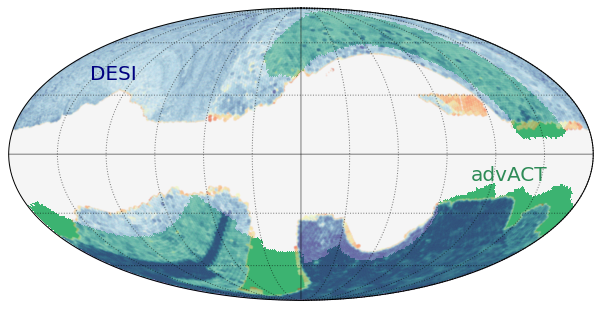

In [72]:
overlap_mask = desi + 2*act
kw = dict(s=1, vmin=21.5, vmax=23.5, cmap='RdYlBu', alpha=0.05)
band='z'
hp.mollview(act_gal, fig=2, cmap=cmap, max=3, cbar=False, notext=True, title=None)
south = Bs[(Bs.get('galdepth_'+band) - Bs.get('ext_'+band))>21.8]
north = Bn[(Bn.get('galdepth_'+band) - Bn.get('ext_'+band))>21.8]
hp.projscatter(south.l,south.b, lonlat=True,c=(south.get('galdepth_'+band) - south.get('ext_'+band)), **kw)
hp.projscatter(north.l,north.b, lonlat=True,c=(north.get('galdepth_'+band) - north.get('ext_'+band)), **kw)

hp.graticule(alpha=0.5)       
hp.projtext(-0.9,-0.5,'DESI',size=20,color='navy')
hp.projtext(1.8,17,'advACT',size=20,color='seagreen')

plt.savefig('coverage_depth.png')

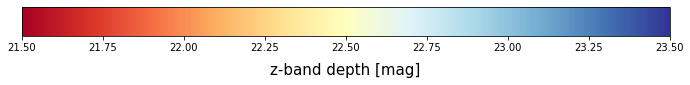

In [73]:
import pylab as pl
import numpy as np

a = np.array([[21.5,23.5]])
pl.figure()
img = pl.imshow(a,cmap='RdYlBu')
pl.gca().set_visible(False)
cax = pl.axes([0.1,0.1,1.5,0.1])
c = pl.colorbar(orientation='horizontal',cax=cax)
c.set_label(label='z-band depth [mag]',size=15,labelpad=10)
pl.savefig('colorbar.png',bbox_inches='tight')

In [47]:
hdul = fits.open('../mask_unWISE_thres_v10.fits',nside=64)

In [48]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'T       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        

In [46]:
hdul2 = fits.open('../project4_EP/overlaps/masks/AdvACT.fits')
hdul2[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                   48 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'T       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        